In [4]:
!pip show tensorflow

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


## **CNN1D + LSTM model to predict category from IMU data with Hyperparameter Tuning**

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import itertools

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [ ]:
SAVED_PLOTS_DIR = r"C:\uni\talent_rec-main (1)\talent_rec-main\newsaved"

In [7]:
df = pd.read_csv(r"C:\uni\movement_with_feedback.csv")

In [8]:
sensor_cols = df.select_dtypes(include=[np.number]).columns
X = df[sensor_cols].values

In [9]:
df = df[df['coach_feedback'] != 'undefined']
y = df['coach_feedback']

X = df[sensor_cols].values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
timesteps = 50
n_features = X_scaled.shape[1]

In [12]:
def create_sequences(X, y, window_size):
    sequences = []
    labels = []
    for i in range(len(X) - window_size):
        sequences.append(X[i:i + window_size])
        labels.append(y.iloc[i + window_size])
    return np.array(sequences), np.array(labels)

In [13]:
X_seq, y_seq = create_sequences(X_scaled, y, timesteps)

In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_seq)
y_cat = to_categorical(y_encoded).astype('float32')

In [15]:
le.classes_

array(['average', 'bad', 'good'], dtype='<U7')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

In [17]:
param_grid = {
    'conv_filters': [32, 64],
    'lstm_units': [32, 64],
    'dropout_rate': [0.3, 0.5],
    'dense_units': [32, 64],
    'epochs': [10, 30, 50, 100],
    'batch_size': [32, 64, 128]
}

In [18]:
best_model = None
best_accuracy = 0
best_params = {}
best_history = None

In [19]:
for params in itertools.product(*param_grid.values()):
    conv_filters, lstm_units, dropout_rate, dense_units, epochs, batch_size = params
    print(f"\nTraining model with params: Conv={conv_filters}, LSTM={lstm_units}, Dropout={dropout_rate}, Dense={dense_units}, batch={batch_size}, epochs={epochs}")

    model = Sequential()
    model.add(Conv1D(filters=conv_filters, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(y_cat.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_params = {
            'conv_filters': conv_filters,
            'lstm_units': lstm_units,
            'dropout_rate': dropout_rate,
            'dense_units': dense_units,
            'epochs': epochs,
            'batch_size': batch_size
        }
        best_history = history



Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=32, epochs=10
Test Accuracy: 0.9722

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=64, epochs=10
Test Accuracy: 0.9663

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=128, epochs=10
Test Accuracy: 0.9742

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=32, epochs=30
Test Accuracy: 0.9683

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=64, epochs=30
Test Accuracy: 0.9742

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=128, epochs=30
Test Accuracy: 0.9702

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=32, epochs=50
Test Accuracy: 0.9742

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=64, epochs=50
Test Accuracy: 0.9663

Training model with params: Conv=32, LSTM=32, Dropout=0.3, Dense=32, batch=128, epochs=50
Test Accura

In [20]:
print(f"\nBest Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")


Best Parameters: {'conv_filters': 64, 'lstm_units': 64, 'dropout_rate': 0.5, 'dense_units': 64, 'epochs': 50, 'batch_size': 32}
Best Accuracy: 0.9921


In [21]:
y_pred_probs = best_model.predict(X_test)
y_pred_class = np.argmax(y_pred_probs, axis=1)
y_test_class = np.argmax(y_test, axis=1)

16/16 [==============================] - 1s 11ms/step


In [22]:
accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class, average='weighted')
roc_auc = roc_curve(y_test_class, y_pred_probs[:, 1]) if y_cat.shape[1] == 2 else (None, None, None)
precision = precision_score(y_test_class, y_pred_class, average='weighted')
recall = recall_score(y_test_class, y_pred_class, average='weighted')
kappa = cohen_kappa_score(y_test_class, y_pred_class)
mcc = matthews_corrcoef(y_test_class, y_pred_class)
rmse = mean_squared_error(y_test_class, y_pred_class, squared=False)

In [23]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
if roc_auc[0] is not None:
    print(f"ROC AUC Score: {auc(*roc_auc[:2]):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Cohen Kappa: {kappa:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"RMSE: {rmse:.4f}")

Accuracy: 0.9921
F1 Score: 0.9921
Precision: 0.9921
Recall: 0.9921
Cohen Kappa: 0.9876
MCC: 0.9876
RMSE: 0.1409


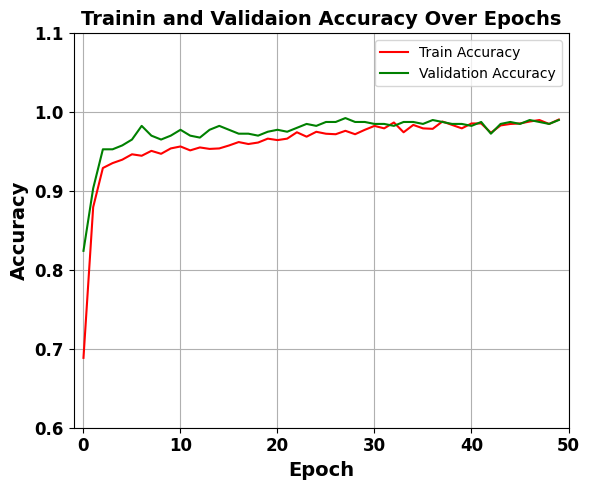

In [24]:
plt.figure(figsize=(6, 5))
plt.plot(best_history.epoch, best_history.history['accuracy'], 's-', markersize=0, color='red', label='Train Accuracy')
plt.plot(best_history.epoch, best_history.history['val_accuracy'], 'o-', markersize=0, color='green', label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Trainin and Validaion Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.xlim(-1, len(best_history.epoch))
plt.ylim(0.6, 1.1)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(SAVED_PLOTS_DIR, "cnn_lstm_accuracy_curve.pdf"), format='pdf')
plt.show()

In [25]:
train_acc = np.array(best_history.history['accuracy'])
val_acc = np.array(best_history.history['val_accuracy'])
overfitting = val_acc -  train_acc

In [26]:
np.mean(overfitting)

0.013250617980957032

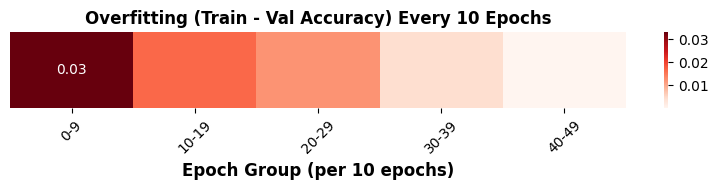

In [27]:
chunk_size = 10
n_chunks = len(overfitting) // chunk_size
overfitting_chunks = [np.mean(overfitting[i*chunk_size:(i+1)*chunk_size]) for i in range(n_chunks)]

plt.figure(figsize=(8, 2))
sns.heatmap(np.array(overfitting_chunks)[np.newaxis, :], cmap='Reds', annot=True, fmt=".2f")
plt.xlabel('Epoch Group (per 10 epochs)', fontsize=12, fontweight='bold')
plt.xticks(np.arange(n_chunks) + 0.5, labels=[f"{i*10}-{(i+1)*10-1}" for i in range(n_chunks)], fontsize=10, rotation=45)
plt.yticks([])
plt.title('Overfitting (Train - Val Accuracy) Every 10 Epochs', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(SAVED_PLOTS_DIR, "cnn_lstm_overfitting_by_10_epochs.pdf"), format='pdf')
plt.show()

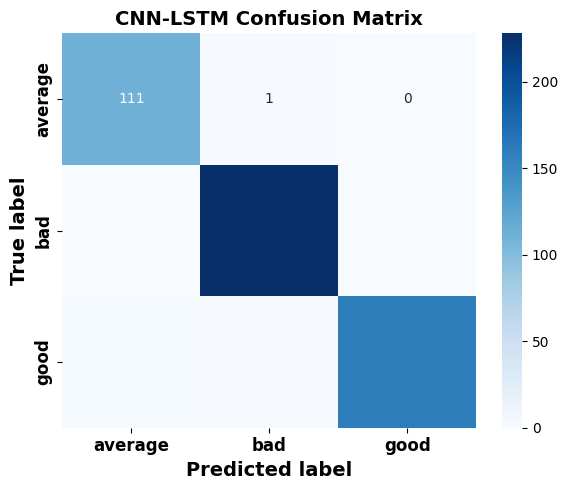

In [28]:
class_names = ['average', 'bad', 'good']

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
plt.title('CNN-LSTM Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(SAVED_PLOTS_DIR, "cnn_lstm_confusion_matrix.pdf"), format='pdf')
plt.show()